## Application: Strikes Duration
---

### Description:

+ a cross-section from 1968 to 1976
+ number of observations : 566
+ country : United States

### Variables:

+ dur - duration of the strike in days
+ gdp - measure of stage of business cycle (deviation of monthly log industrial production in manufacturing from prediction from OLS on time, time-squared and monthly dummies)

### Source:

Kennan, J. (1985) “The Duration of Contract strikes in U.S. Manufacturing”, Journal of Econometrics, 28, 5-28.

### Reference:

Cameron, A.C. and P.K. Trivedi (2005) Microeconometrics : methods and applications, Cambridge, pp. 574–5 and 582.

https://vincentarelbundock.github.io/Rdatasets/datasets.html


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from IPython.display import display
pd.set_option('future.no_silent_downcasting', True)

### Strikes duration

$$
  p(y_{i}|\theta_{i}) = \frac1{\theta_{i}}e^{-\frac{y_{i}}{\theta_{i}}},\quad
  \log\theta_{i} = \text{constant} + \beta\ \text{gdp}.
$$


In [2]:
strikes_data = pd.read_csv('StrikeDur.csv', index_col=0)
strikes_duration = strikes_data['dur'].to_numpy(dtype='float64')
gdp = strikes_data['gdp'].to_numpy(dtype='float64')
y = strikes_duration
X = np.stack((np.ones(len(strikes_duration)), gdp), axis=1)
var_names = ['constant', 'gdp']

In [3]:
k = X.shape[1]
b0, A0 = np.zeros(k), 0.01 * np.eye(k)
exponential_duration_model = pm.Model()
with exponential_duration_model:
    y_data = pm.Data('y_data', y)
    X_data = pm.Data('X_data', X)
    b = pm.MvNormal('b', mu=b0, tau=A0, shape=k)
    idx = X_data @ b
    likelihood = pm.Exponential('y', lam=pm.math.exp(-idx), observed=y_data)

In [4]:
n_draws, n_chains, n_tune = 5000, 4, 1000
with exponential_duration_model:
    # trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, target_accept=0.9, random_seed=123) # PyMC default sampler (very slow)
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, target_accept=0.9, random_seed=123, nuts_sampler='numpyro') # numpyro (much faster but does not work on Colab)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [5]:
results = pm.summary(trace, hdi_prob=0.95)
results.index = var_names
sim_param = dict([(var, trace.posterior['b'].to_numpy()[:, :, index]) for index, var in enumerate(var_names)])
display(results)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
constant,3.784,0.042,3.700,3.865,0.000,0.000,14183.0,12993.0,1.0
gdp,-2.501,0.835,-4.105,-0.855,0.007,0.006,13503.0,12233.0,1.0


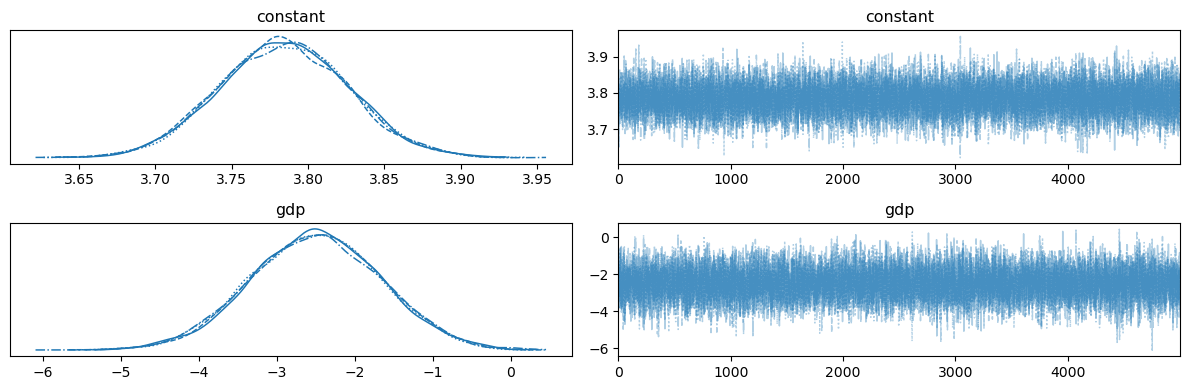

In [6]:
pm.plot_trace(sim_param)
plt.tight_layout()
plt.show()

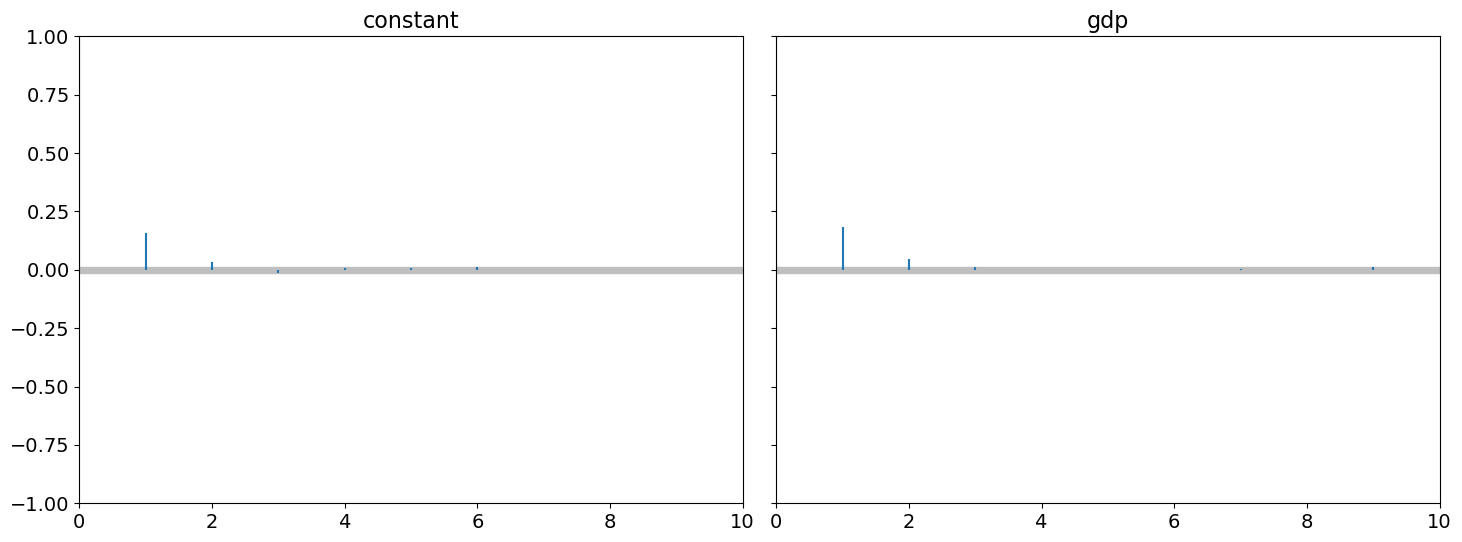

In [7]:
pm.plot_autocorr(sim_param, max_lag=10, combined=True)
plt.tight_layout()
plt.show()

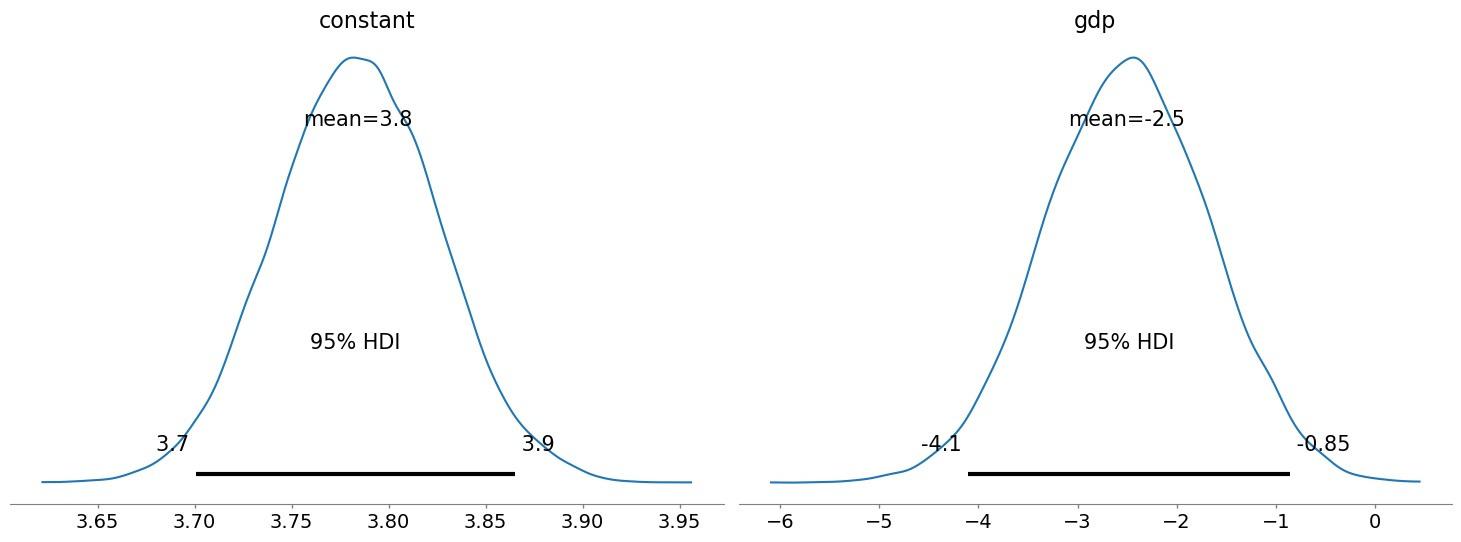

In [8]:
pm.plot_posterior(sim_param, kind='kde', point_estimate='mean', hdi_prob=0.95)
plt.tight_layout()
plt.show()